In [6]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import torch
import neuralnetworkclassifier as nnc
import dataset_manipulations as dm
import perturb as per
import numpy as np
import mlutils as ml
import pickle

import matplotlib.pyplot as plt

In [2]:
Xtrain, Ttrain = dm.load_cifar_10('./cifar-10-batches-py/data_batch_*')
Xtest, Ttest = dm.load_cifar_10('./cifar-10-batches-py/test_batch')

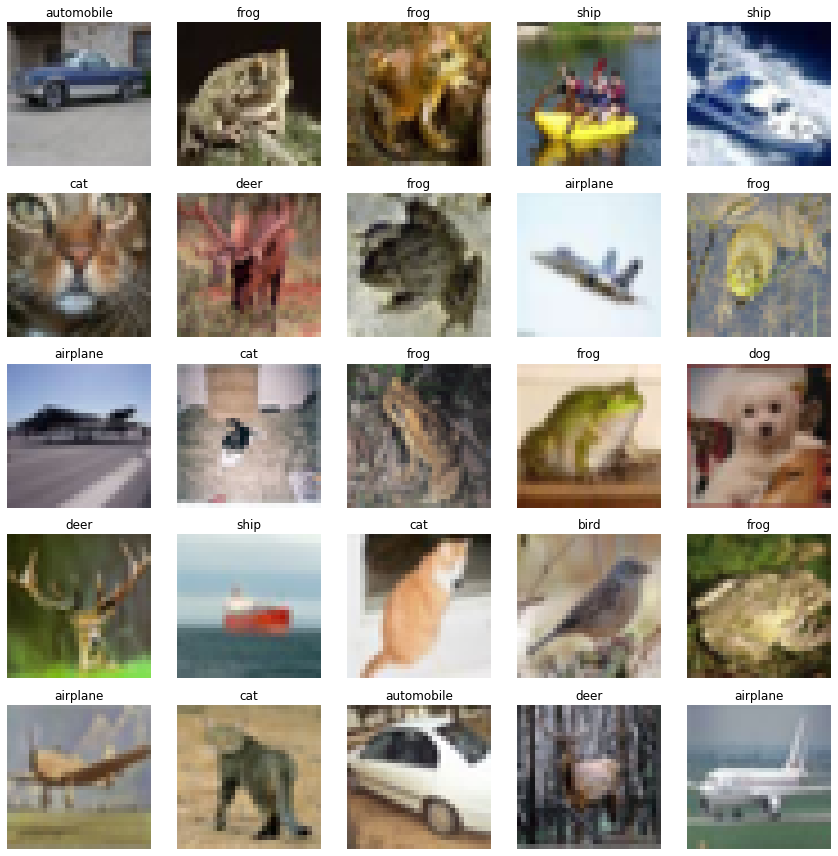

In [8]:
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

def imshow(Xset, Tset):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.moveaxis(Xset[i,...], 0, 2), interpolation='nearest')
        plt.axis('off')
        unicode = class_names[Tset[i][0]].decode('utf-8')
        plt.title(unicode) 

    plt.tight_layout()
    
imshow(Xtrain, Ttrain)

In [9]:
noise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.05))
noise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.05))

In [10]:
lessnoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.025))
lessnoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.0025)) 

In [13]:
import imp
imp.reload(nnc)

<module 'neuralnetworkclassifier' from '../src/neuralnetworkclassifier.py'>

In [14]:
nnet = per.train_cifar(Xtrain, Ttrain, verbose=True)

Epoch 2 error 0.69121
Epoch 4 error 0.62654
Epoch 6 error 0.34781
Epoch 8 error 0.19689
Epoch 10 error 0.14031
Epoch 12 error 0.08767
Epoch 14 error 0.11188
Epoch 16 error 0.10503
Epoch 18 error 0.09256
Epoch 20 error 0.05583


In [15]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                            kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                            max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest))
(clean_pct, lessnoise_pct, noise_pct)

(84.86, 84.88, 68.81)

FloatProgress(value=0.0, max=125.0)

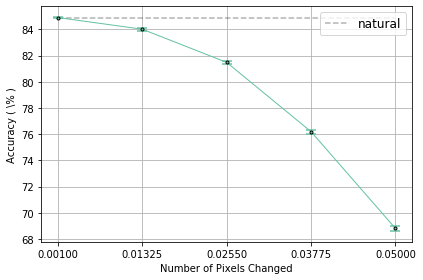

In [17]:
per.test_increasing_noise(nnet, Xtest, Ttest, (0.001, 0.05), 5, 25, name='media/TESTING_RM_ME.pdf')

In [ ]:
nnet.nnet[-1].in_features

In [ ]:
other_network = nnet.transfer_learn_setup([torch.nn.Linear(2048, 256), torch.nn.ReLU(), torch.nn.Linear(256, 10)])
other_network

In [ ]:
nnet.nnet = other_network

In [ ]:
nnet.train(noise_Xtrain, Ttrain, n_epochs=10, batch_size=200,
           optim='Adam', learning_rate=0.0005, verbose=True)

In [ ]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest))
(clean_pct, noise_pct, lessnoise_pct)